# 데이터 로드

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import shap

plt.rcParams['font.family'] = 'Malgun Gothic'


In [19]:
df = pd.read_csv('data_2.csv', dtype={'isbn': str})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3316 entries, 0 to 3315
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   isbn               3316 non-null   object 
 1   title              3316 non-null   object 
 2   publishDate        3316 non-null   int64  
 3   price              3316 non-null   int64  
 4   pageCount          3316 non-null   int64  
 5   size               3316 non-null   float64
 6   weight             3316 non-null   int64  
 7   label              3316 non-null   int64  
 8   author_name_tf     3316 non-null   int64  
 9   publisher_name_tf  3316 non-null   int64  
dtypes: float64(1), int64(7), object(2)
memory usage: 259.2+ KB


In [20]:
df.head()
df.describe()
df.isnull().sum()

isbn                 0
title                0
publishDate          0
price                0
pageCount            0
size                 0
weight               0
label                0
author_name_tf       0
publisher_name_tf    0
dtype: int64

In [21]:
# 두 CSV 파일 불러오기 (isbn을 문자열로 처리)
keyword_best = pd.read_csv('mecab keyword(베스트).csv', dtype={'isbn': str})
keyword_book = pd.read_csv('mecab keyword(일반).csv', dtype={'isbn': str})

# 컬럼 이름 확인
best_columns = keyword_best.columns.tolist()
book_columns = keyword_book.columns.tolist()

best_columns, book_columns


(['topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'isbn'],
 ['topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'isbn'])

In [22]:
df_best = df[df['label'] == 1].copy()
df_book = df[df['label'] == 0].copy()

print("베스트셀러 수:", len(df_best))
print("일반 도서 수:", len(df_book))

베스트셀러 수: 1000
일반 도서 수: 2316


In [23]:
df_best = df_best.merge(keyword_best, on='isbn', how='left')
df_book = df_book.merge(keyword_book, on='isbn', how='left')


In [24]:
df = pd.concat([df_best, df_book], ignore_index=True)
print(df.shape)

(3316, 16)


In [25]:
df[['topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5']].head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5
0,0.005781,0.003096,0.006070,0.005778,0.004806,0.974469
1,0.000781,0.644215,0.000820,0.151553,0.202110,0.000523
2,0.000660,0.000353,0.000693,0.706756,0.000548,0.290990
3,0.001478,0.993275,0.001552,0.001477,0.001229,0.000990
4,0.001208,0.000647,0.674994,0.321337,0.001004,0.000809


In [26]:
for i in range(6):
    df[f'topic_{i}'] = df[f'topic_{i}'].fillna(0)

# 확인
df[['topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5']].isnull().sum()


topic_0    0
topic_1    0
topic_2    0
topic_3    0
topic_4    0
topic_5    0
dtype: int64

# 이상치

In [27]:
# numeric_cols = ['price', 'pageCount', 'size', 'weight']
# for col in numeric_cols:
#     sns.boxplot(x=df[col])
#     plt.title(f'{col} Boxplot')
#     plt.show()

In [28]:
# import numpy as np

# # size를 제외한 컬럼에 log1p 변환 적용
# df['price_log'] = np.log1p(df['price'])
# df['pageCount_log'] = np.log1p(df['pageCount'])
# df['weight_log'] = np.log1p(df['weight'])

# # 변환된 결과의 기술통계 확인
# log_transformed_stats = df[['price_log', 'pageCount_log', 'weight_log']].describe()
# log_transformed_stats


# XGB

In [29]:
X = df.drop(columns=['isbn', 'title', 'label'])  # 또는 title 제외 안 할 수도 있음
y = df['label']

In [30]:
from sklearn.model_selection import train_test_split

# 먼저 train (70%) vs temp (30%) 분할
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# temp (30%)을 다시 validation: test = 2:1 비율로 나눔 (즉, 20%, 10%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=1/3, random_state=42
)

# 크기 확인
X_train.shape, X_val.shape, X_test.shape

((2321, 13), (663, 13), (332, 13))

In [31]:
import optuna
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1️⃣ 기본 모델 (그대로 유지)
basic_model = xgb.XGBClassifier(eval_metric='logloss', random_state=42)
basic_model.fit(X_train, y_train)
y_val_pred_basic = basic_model.predict(X_val)

results = []
results.append({
    'name': 'XGB_baseline',
    'model': basic_model,
    'conf_matrix': confusion_matrix(y_val, y_val_pred_basic),
    'report': classification_report(y_val, y_val_pred_basic, output_dict=False)
})

# 2️⃣ Optuna 목적 함수 (넓은 파라미터 공간)
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        'use_label_encoder': False,
        'eval_metric': 'logloss',
        'random_state': 42
    }

    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    return accuracy_score(y_val, preds)

# 3️⃣ 베이지안 최적화 실행
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, show_progress_bar=True)

# 4️⃣ 최적 모델로 학습 및 결과 저장
best_params = study.best_trial.params
best_model = xgb.XGBClassifier(**best_params)
best_model.fit(X_train, y_train)
y_val_pred_tuned = best_model.predict(X_val)

results.append({
    'name': 'XGB_optuna',
    'model': best_model,
    'conf_matrix': confusion_matrix(y_val, y_val_pred_tuned),
    'report': classification_report(y_val, y_val_pred_tuned, output_dict=False),
    'best_params': best_params
})

# 5️⃣ 결과 출력
for res in results:
    print(f"\n==== {res['name']} ====")
    print(res['conf_matrix'])
    print(res['report'])
    if 'best_params' in res:
        print("Best Params:", res['best_params'])

[I 2025-06-07 15:48:25,803] A new study created in memory with name: no-name-26a1bb90-c669-4378-af43-b78928388ba8


  0%|          | 0/100 [00:00<?, ?it/s]

c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:48:26,061] Trial 0 finished with value: 0.9441930618401206 and parameters: {'max_depth': 5, 'learning_rate': 0.023850376844265105, 'n_estimators': 700, 'subsample': 0.8709382188368002, 'colsample_bytree': 0.9565486605334723, 'gamma': 0.6340817187736014, 'min_child_weight': 1, 'reg_alpha': 0.8854113478635658, 'reg_lambda': 3.301211986515024}. Best is trial 0 with value: 0.9441930618401206.
[I 2025-06-07 15:48:26,155] Trial 1 finished with value: 0.9321266968325792 and parameters: {'max_depth': 10, 'learning_rate': 0.005372152722553702, 'n_estimators': 200, 'subsample': 0.7938401802709987, 'colsample_bytree': 0.8848130517850402, 'gamma': 3.1068692203800325, 'min_child_weight': 5, 'reg_alpha': 0.4323084097445429, 'reg_lambda': 9.56920116777068}. Best is trial 0 with value: 0.9441930618401206.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:48:26,339] Trial 2 finished with value: 0.9396681749622926 and parameters: {'max_depth': 7, 'learning_rate': 0.054185043577478074, 'n_estimators': 1000, 'subsample': 0.5128927396817036, 'colsample_bytree': 0.8408892794566571, 'gamma': 4.108469706841537, 'min_child_weight': 4, 'reg_alpha': 0.29022207685789214, 'reg_lambda': 5.168548743767892}. Best is trial 0 with value: 0.9441930618401206.
[I 2025-06-07 15:48:26,475] Trial 3 finished with value: 0.942684766214178 and parameters: {'max_depth': 8, 'learning_rate': 0.017229459719611286, 'n_estimators': 400, 'subsample': 0.9957500066440469, 'colsample_bytree': 0.9119077173388457, 'gamma': 4.749771537671086, 'min_child_weight': 3, 'reg_alpha': 0.6708950645129648, 'reg_lambda': 6.124540216547376}. Best is trial 0 with value: 0.9441930618401206.
[I 2025-06-07 15:48:26,510] Trial 4 finished with value: 0.9381598793363499 and parameters: {'max_depth': 8, 'learning_rate': 0.16242498222685361, 'n_estimators': 100, 'subsample': 0.

c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:48:26,831] Trial 5 finished with value: 0.942684766214178 and parameters: {'max_depth': 5, 'learning_rate': 0.011137242294030068, 'n_estimators': 900, 'subsample': 0.9563953760801155, 'colsample_bytree': 0.7455523052712395, 'gamma': 1.6057312932467394, 'min_child_weight': 8, 'reg_alpha': 0.20705179819765207, 'reg_lambda': 4.218475316522648}. Best is trial 0 with value: 0.9441930618401206.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:48:27,258] Trial 6 finished with value: 0.9366515837104072 and parameters: {'max_depth': 9, 'learning_rate': 0.006239533401337447, 'n_estimators': 900, 'subsample': 0.695203238779946, 'colsample_bytree': 0.9153714703012013, 'gamma': 1.2388231385581194, 'min_child_weight': 6, 'reg_alpha': 0.07530135273155392, 'reg_lambda': 1.08872645165341}. Best is trial 0 with value: 0.9441930618401206.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:48:27,487] Trial 7 finished with value: 0.942684766214178 and parameters: {'max_depth': 3, 'learning_rate': 0.028641195164625172, 'n_estimators': 1000, 'subsample': 0.5032106699419323, 'colsample_bytree': 0.7576988037640323, 'gamma': 2.31297174845451, 'min_child_weight': 6, 'reg_alpha': 0.40234189462023695, 'reg_lambda': 9.180411149880856}. Best is trial 0 with value: 0.9441930618401206.
[I 2025-06-07 15:48:27,588] Trial 8 finished with value: 0.9411764705882353 and parameters: {'max_depth': 4, 'learning_rate': 0.027945760843969165, 'n_estimators': 400, 'subsample': 0.5856064450798583, 'colsample_bytree': 0.9782390669479275, 'gamma': 4.420704261288611, 'min_child_weight': 4, 'reg_alpha': 0.42305727651873304, 'reg_lambda': 8.823203470848934}. Best is trial 0 with value: 0.9441930618401206.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:48:27,686] Trial 9 finished with value: 0.9411764705882353 and parameters: {'max_depth': 4, 'learning_rate': 0.10088228309183313, 'n_estimators': 500, 'subsample': 0.6172923473404226, 'colsample_bytree': 0.9133955405101049, 'gamma': 2.735877261506391, 'min_child_weight': 7, 'reg_alpha': 0.7183202753280125, 'reg_lambda': 5.534922899917922}. Best is trial 0 with value: 0.9441930618401206.
[I 2025-06-07 15:48:27,942] Trial 10 finished with value: 0.947209653092006 and parameters: {'max_depth': 6, 'learning_rate': 0.05805240017145766, 'n_estimators': 700, 'subsample': 0.8773170172514575, 'colsample_bytree': 0.5939324255131047, 'gamma': 0.010530113982687439, 'min_child_weight': 1, 'reg_alpha': 0.9775395781558344, 'reg_lambda': 0.1709628365957201}. Best is trial 10 with value: 0.947209653092006.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:48:28,215] Trial 11 finished with value: 0.947209653092006 and parameters: {'max_depth': 6, 'learning_rate': 0.05917979871127971, 'n_estimators': 700, 'subsample': 0.8841163729273738, 'colsample_bytree': 0.5718101442356698, 'gamma': 0.01106166244236062, 'min_child_weight': 1, 'reg_alpha': 0.9419352206731688, 'reg_lambda': 0.3459853111777773}. Best is trial 10 with value: 0.947209653092006.
[I 2025-06-07 15:48:28,413] Trial 12 finished with value: 0.9502262443438914 and parameters: {'max_depth': 6, 'learning_rate': 0.06257229726182413, 'n_estimators': 700, 'subsample': 0.9006100373166346, 'colsample_bytree': 0.5688815655062098, 'gamma': 0.24232973025508497, 'min_child_weight': 1, 'reg_alpha': 0.9704014847420886, 'reg_lambda': 0.12011375896186134}. Best is trial 12 with value: 0.9502262443438914.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:48:28,660] Trial 13 finished with value: 0.947209653092006 and parameters: {'max_depth': 6, 'learning_rate': 0.0576801087175924, 'n_estimators': 700, 'subsample': 0.8763890166693359, 'colsample_bytree': 0.5286938818073592, 'gamma': 0.059550285615450976, 'min_child_weight': 2, 'reg_alpha': 0.9930102322735764, 'reg_lambda': 2.150344100364079}. Best is trial 12 with value: 0.9502262443438914.
[I 2025-06-07 15:48:28,805] Trial 14 finished with value: 0.942684766214178 and parameters: {'max_depth': 7, 'learning_rate': 0.11304224278969184, 'n_estimators': 600, 'subsample': 0.9296915466918839, 'colsample_bytree': 0.6194702929347004, 'gamma': 1.0679109839435086, 'min_child_weight': 10, 'reg_alpha': 0.7893178060875099, 'reg_lambda': 1.9396003129943158}. Best is trial 12 with value: 0.9502262443438914.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:48:28,990] Trial 15 finished with value: 0.9502262443438914 and parameters: {'max_depth': 5, 'learning_rate': 0.0481671944896869, 'n_estimators': 800, 'subsample': 0.8207111392748369, 'colsample_bytree': 0.6411215609119731, 'gamma': 1.9325417599954724, 'min_child_weight': 2, 'reg_alpha': 0.8431405063528061, 'reg_lambda': 0.1960580861774792}. Best is trial 12 with value: 0.9502262443438914.
[I 2025-06-07 15:48:29,181] Trial 16 finished with value: 0.9457013574660633 and parameters: {'max_depth': 5, 'learning_rate': 0.09010259021373891, 'n_estimators': 900, 'subsample': 0.719476035263557, 'colsample_bytree': 0.6693870120081539, 'gamma': 1.9990085426150697, 'min_child_weight': 3, 'reg_alpha': 0.5739637010307844, 'reg_lambda': 2.777592263355125}. Best is trial 12 with value: 0.9502262443438914.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:48:29,354] Trial 17 finished with value: 0.9396681749622926 and parameters: {'max_depth': 3, 'learning_rate': 0.041232465893190705, 'n_estimators': 800, 'subsample': 0.8218219664850672, 'colsample_bytree': 0.5025081521914615, 'gamma': 3.571674240934435, 'min_child_weight': 2, 'reg_alpha': 0.8430695787215107, 'reg_lambda': 1.5539442774335857}. Best is trial 12 with value: 0.9502262443438914.
[I 2025-06-07 15:48:29,488] Trial 18 finished with value: 0.9441930618401206 and parameters: {'max_depth': 4, 'learning_rate': 0.19180620871898071, 'n_estimators': 500, 'subsample': 0.6643276622460529, 'colsample_bytree': 0.682267778721487, 'gamma': 0.8237534244282501, 'min_child_weight': 3, 'reg_alpha': 0.5421562367084662, 'reg_lambda': 7.491442504262628}. Best is trial 12 with value: 0.9502262443438914.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:48:29,817] Trial 19 finished with value: 0.9457013574660633 and parameters: {'max_depth': 8, 'learning_rate': 0.01718345025050357, 'n_estimators': 800, 'subsample': 0.8209873088310328, 'colsample_bytree': 0.6729020363256799, 'gamma': 1.679796610262275, 'min_child_weight': 2, 'reg_alpha': 0.7923249500537781, 'reg_lambda': 3.974892012744122}. Best is trial 12 with value: 0.9502262443438914.
[I 2025-06-07 15:48:30,024] Trial 20 finished with value: 0.9381598793363499 and parameters: {'max_depth': 7, 'learning_rate': 0.04014856322481908, 'n_estimators': 600, 'subsample': 0.738483637956157, 'colsample_bytree': 0.5580123708519112, 'gamma': 3.1400305686782817, 'min_child_weight': 4, 'reg_alpha': 0.874018230749073, 'reg_lambda': 0.8537886204261032}. Best is trial 12 with value: 0.9502262443438914.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:48:30,230] Trial 21 finished with value: 0.951734539969834 and parameters: {'max_depth': 6, 'learning_rate': 0.07923123308826398, 'n_estimators': 800, 'subsample': 0.9187183416432063, 'colsample_bytree': 0.6311187448681996, 'gamma': 0.5328849324043972, 'min_child_weight': 1, 'reg_alpha': 0.9869942652337892, 'reg_lambda': 0.011469727983908384}. Best is trial 21 with value: 0.951734539969834.
[I 2025-06-07 15:48:30,411] Trial 22 finished with value: 0.9502262443438914 and parameters: {'max_depth': 5, 'learning_rate': 0.0809829325627438, 'n_estimators': 800, 'subsample': 0.9387704846462691, 'colsample_bytree': 0.6350481309353551, 'gamma': 0.557990873931531, 'min_child_weight': 1, 'reg_alpha': 0.9253507442460784, 'reg_lambda': 0.3678341223322088}. Best is trial 21 with value: 0.951734539969834.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:48:30,592] Trial 23 finished with value: 0.947209653092006 and parameters: {'max_depth': 6, 'learning_rate': 0.13341818230762495, 'n_estimators': 800, 'subsample': 0.832270490156975, 'colsample_bytree': 0.7009754125031347, 'gamma': 1.4011126410056596, 'min_child_weight': 2, 'reg_alpha': 0.7631388385720879, 'reg_lambda': 2.5557372647259577}. Best is trial 21 with value: 0.951734539969834.
[I 2025-06-07 15:48:30,742] Trial 24 finished with value: 0.9487179487179487 and parameters: {'max_depth': 5, 'learning_rate': 0.07936444746730914, 'n_estimators': 600, 'subsample': 0.9986491151592419, 'colsample_bytree': 0.6179258680616829, 'gamma': 0.423267375000594, 'min_child_weight': 1, 'reg_alpha': 0.9861898898421325, 'reg_lambda': 1.405485550878988}. Best is trial 21 with value: 0.951734539969834.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:48:30,957] Trial 25 finished with value: 0.9457013574660633 and parameters: {'max_depth': 7, 'learning_rate': 0.03853263365319677, 'n_estimators': 900, 'subsample': 0.9113055264867993, 'colsample_bytree': 0.5518629762488942, 'gamma': 2.011740780370506, 'min_child_weight': 3, 'reg_alpha': 0.8489477756982484, 'reg_lambda': 0.03933364848051925}. Best is trial 21 with value: 0.951734539969834.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:48:31,204] Trial 26 finished with value: 0.9457013574660633 and parameters: {'max_depth': 4, 'learning_rate': 0.0701801265864248, 'n_estimators': 1000, 'subsample': 0.7735972270120677, 'colsample_bytree': 0.6393755310548671, 'gamma': 0.9164601269747876, 'min_child_weight': 2, 'reg_alpha': 0.6617393462597887, 'reg_lambda': 0.9922007270610397}. Best is trial 21 with value: 0.951734539969834.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:48:31,498] Trial 27 finished with value: 0.9457013574660633 and parameters: {'max_depth': 6, 'learning_rate': 0.04495511830836567, 'n_estimators': 800, 'subsample': 0.9591422419665365, 'colsample_bytree': 0.7257191441136189, 'gamma': 0.3179782149305271, 'min_child_weight': 10, 'reg_alpha': 0.9138947469119311, 'reg_lambda': 3.314381558283895}. Best is trial 21 with value: 0.951734539969834.
[I 2025-06-07 15:48:31,646] Trial 28 finished with value: 0.947209653092006 and parameters: {'max_depth': 5, 'learning_rate': 0.11589756423747553, 'n_estimators': 400, 'subsample': 0.8597958172144317, 'colsample_bytree': 0.5929309515977136, 'gamma': 1.9219152711830265, 'min_child_weight': 1, 'reg_alpha': 0.8251293080000741, 'reg_lambda': 7.0372391123620215}. Best is trial 21 with value: 0.951734539969834.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:48:31,972] Trial 29 finished with value: 0.947209653092006 and parameters: {'max_depth': 6, 'learning_rate': 0.020180787810698732, 'n_estimators': 700, 'subsample': 0.9043673390802047, 'colsample_bytree': 0.5059579167703808, 'gamma': 0.691182931964173, 'min_child_weight': 1, 'reg_alpha': 0.9043107755042868, 'reg_lambda': 3.5846792556110167}. Best is trial 21 with value: 0.951734539969834.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:48:32,202] Trial 30 finished with value: 0.9411764705882353 and parameters: {'max_depth': 5, 'learning_rate': 0.03511243715232874, 'n_estimators': 700, 'subsample': 0.848491465444572, 'colsample_bytree': 0.6493712189340609, 'gamma': 2.729091061136331, 'min_child_weight': 5, 'reg_alpha': 0.734699243691775, 'reg_lambda': 2.6947550077804228}. Best is trial 21 with value: 0.951734539969834.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:48:32,481] Trial 31 finished with value: 0.9457013574660633 and parameters: {'max_depth': 5, 'learning_rate': 0.07364666664464671, 'n_estimators': 800, 'subsample': 0.940721293150962, 'colsample_bytree': 0.5981093973661049, 'gamma': 0.5400714629665065, 'min_child_weight': 1, 'reg_alpha': 0.9195585331141078, 'reg_lambda': 0.6723633196731758}. Best is trial 21 with value: 0.951734539969834.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:48:32,710] Trial 32 finished with value: 0.942684766214178 and parameters: {'max_depth': 4, 'learning_rate': 0.08349745692579705, 'n_estimators': 900, 'subsample': 0.9724551512711502, 'colsample_bytree': 0.7089029852736622, 'gamma': 1.1359380281046536, 'min_child_weight': 2, 'reg_alpha': 0.9987073970815896, 'reg_lambda': 0.009073942228196241}. Best is trial 21 with value: 0.951734539969834.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:48:33,007] Trial 33 finished with value: 0.9487179487179487 and parameters: {'max_depth': 6, 'learning_rate': 0.04793290218959108, 'n_estimators': 800, 'subsample': 0.9118467612084373, 'colsample_bytree': 0.816769453684905, 'gamma': 0.3682890174202008, 'min_child_weight': 1, 'reg_alpha': 0.8888946925543161, 'reg_lambda': 1.9444975846900299}. Best is trial 21 with value: 0.951734539969834.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:48:33,335] Trial 34 finished with value: 0.9502262443438914 and parameters: {'max_depth': 7, 'learning_rate': 0.06555892026538246, 'n_estimators': 600, 'subsample': 0.7971856511442001, 'colsample_bytree': 0.6411478166026994, 'gamma': 0.6424815020557451, 'min_child_weight': 3, 'reg_alpha': 0.9379157867623084, 'reg_lambda': 0.73331722072569}. Best is trial 21 with value: 0.951734539969834.
[I 2025-06-07 15:48:33,528] Trial 35 finished with value: 0.9502262443438914 and parameters: {'max_depth': 10, 'learning_rate': 0.1346143601816123, 'n_estimators': 700, 'subsample': 0.8998922424237783, 'colsample_bytree': 0.5398007222884875, 'gamma': 1.5016003463718612, 'min_child_weight': 2, 'reg_alpha': 0.8306394335116567, 'reg_lambda': 1.6263608231601834}. Best is trial 21 with value: 0.951734539969834.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:48:33,795] Trial 36 finished with value: 0.951734539969834 and parameters: {'max_depth': 5, 'learning_rate': 0.09515226859083767, 'n_estimators': 1000, 'subsample': 0.932167551710191, 'colsample_bytree': 0.6227478041832363, 'gamma': 0.25965141976000466, 'min_child_weight': 1, 'reg_alpha': 0.6642014307657123, 'reg_lambda': 0.5667971880880113}. Best is trial 21 with value: 0.951734539969834.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:48:34,031] Trial 37 finished with value: 0.9547511312217195 and parameters: {'max_depth': 8, 'learning_rate': 0.155547880350279, 'n_estimators': 1000, 'subsample': 0.8522781641827604, 'colsample_bytree': 0.5772643599176438, 'gamma': 0.2479340282276028, 'min_child_weight': 4, 'reg_alpha': 0.6044881654627245, 'reg_lambda': 1.165079363136975}. Best is trial 37 with value: 0.9547511312217195.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:48:34,266] Trial 38 finished with value: 0.9487179487179487 and parameters: {'max_depth': 8, 'learning_rate': 0.19302985988020044, 'n_estimators': 1000, 'subsample': 0.9760239884553393, 'colsample_bytree': 0.5231547554827534, 'gamma': 0.2378105223726077, 'min_child_weight': 4, 'reg_alpha': 0.6136500544149566, 'reg_lambda': 1.3302706287980461}. Best is trial 37 with value: 0.9547511312217195.
[I 2025-06-07 15:48:34,479] Trial 39 finished with value: 0.9441930618401206 and parameters: {'max_depth': 9, 'learning_rate': 0.1421800775465113, 'n_estimators': 1000, 'subsample': 0.8568723231105282, 'colsample_bytree': 0.5685584041839337, 'gamma': 0.9912905177254652, 'min_child_weight': 8, 'reg_alpha': 0.4845879935705525, 'reg_lambda': 4.64872122707185}. Best is trial 37 with value: 0.9547511312217195.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:48:34,737] Trial 40 finished with value: 0.951734539969834 and parameters: {'max_depth': 9, 'learning_rate': 0.09208842720842023, 'n_estimators': 1000, 'subsample': 0.929625636357562, 'colsample_bytree': 0.5843072919581381, 'gamma': 0.1970469489180423, 'min_child_weight': 7, 'reg_alpha': 0.3767132531092596, 'reg_lambda': 2.276498510902891}. Best is trial 37 with value: 0.9547511312217195.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:48:34,993] Trial 41 finished with value: 0.9457013574660633 and parameters: {'max_depth': 9, 'learning_rate': 0.10156788921673433, 'n_estimators': 1000, 'subsample': 0.9336824546890118, 'colsample_bytree': 0.5844434022353157, 'gamma': 0.23868967311557898, 'min_child_weight': 7, 'reg_alpha': 0.2777591812702152, 'reg_lambda': 0.7649702002128456}. Best is trial 37 with value: 0.9547511312217195.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:48:35,214] Trial 42 finished with value: 0.9411764705882353 and parameters: {'max_depth': 9, 'learning_rate': 0.1678842145947859, 'n_estimators': 900, 'subsample': 0.9701167501648856, 'colsample_bytree': 0.6157346155816974, 'gamma': 0.7831093966612459, 'min_child_weight': 7, 'reg_alpha': 0.3138289438315708, 'reg_lambda': 2.050085122916189}. Best is trial 37 with value: 0.9547511312217195.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:48:35,531] Trial 43 finished with value: 0.947209653092006 and parameters: {'max_depth': 8, 'learning_rate': 0.10180501448683826, 'n_estimators': 1000, 'subsample': 0.8895996129188872, 'colsample_bytree': 0.5463575741143449, 'gamma': 0.1820007436511652, 'min_child_weight': 5, 'reg_alpha': 0.3826148050160961, 'reg_lambda': 1.1821936514002336}. Best is trial 37 with value: 0.9547511312217195.
[I 2025-06-07 15:48:35,653] Trial 44 finished with value: 0.9457013574660633 and parameters: {'max_depth': 10, 'learning_rate': 0.1591405481035282, 'n_estimators': 300, 'subsample': 0.9271320223336754, 'colsample_bytree': 0.6093456405595713, 'gamma': 0.4931562889814354, 'min_child_weight': 8, 'reg_alpha': 0.4843080715172854, 'reg_lambda': 0.6303939468550023}. Best is trial 37 with value: 0.9547511312217195.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:48:35,964] Trial 45 finished with value: 0.9502262443438914 and parameters: {'max_depth': 7, 'learning_rate': 0.1252704290861111, 'n_estimators': 900, 'subsample': 0.9876761655004569, 'colsample_bytree': 0.5753856665093772, 'gamma': 0.006332158977427449, 'min_child_weight': 9, 'reg_alpha': 0.22626025037876563, 'reg_lambda': 2.3531027410848537}. Best is trial 37 with value: 0.9547511312217195.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:48:36,198] Trial 46 finished with value: 0.9457013574660633 and parameters: {'max_depth': 8, 'learning_rate': 0.09541663051688004, 'n_estimators': 900, 'subsample': 0.9458197426662273, 'colsample_bytree': 0.5240419672340071, 'gamma': 1.3421335800568246, 'min_child_weight': 6, 'reg_alpha': 0.10648361528931283, 'reg_lambda': 3.039027637812739}. Best is trial 37 with value: 0.9547511312217195.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:48:36,406] Trial 47 finished with value: 0.9366515837104072 and parameters: {'max_depth': 10, 'learning_rate': 0.15500104403660922, 'n_estimators': 1000, 'subsample': 0.8705289662362441, 'colsample_bytree': 0.8545171296272087, 'gamma': 4.772595589393862, 'min_child_weight': 6, 'reg_alpha': 0.37493885164941376, 'reg_lambda': 1.7254189714704813}. Best is trial 37 with value: 0.9547511312217195.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:48:36,670] Trial 48 finished with value: 0.9487179487179487 and parameters: {'max_depth': 9, 'learning_rate': 0.06635844563519713, 'n_estimators': 900, 'subsample': 0.5440420131229089, 'colsample_bytree': 0.6565268123403283, 'gamma': 0.7742360246685083, 'min_child_weight': 5, 'reg_alpha': 0.6865885979133803, 'reg_lambda': 1.190659160922166}. Best is trial 37 with value: 0.9547511312217195.
[I 2025-06-07 15:48:36,769] Trial 49 finished with value: 0.9411764705882353 and parameters: {'max_depth': 8, 'learning_rate': 0.05289882862518169, 'n_estimators': 100, 'subsample': 0.7916205935006223, 'colsample_bytree': 0.7934620387182924, 'gamma': 0.20706943539983033, 'min_child_weight': 9, 'reg_alpha': 0.5418433871104074, 'reg_lambda': 0.40211760896874094}. Best is trial 37 with value: 0.9547511312217195.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:48:37,234] Trial 50 finished with value: 0.9366515837104072 and parameters: {'max_depth': 7, 'learning_rate': 0.00587066546400892, 'n_estimators': 1000, 'subsample': 0.8387741682031886, 'colsample_bytree': 0.7559348061524059, 'gamma': 1.1971172645803, 'min_child_weight': 7, 'reg_alpha': 0.44738135076283236, 'reg_lambda': 5.15401422151613}. Best is trial 37 with value: 0.9547511312217195.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:48:37,648] Trial 51 finished with value: 0.942684766214178 and parameters: {'max_depth': 6, 'learning_rate': 0.007770605970170203, 'n_estimators': 900, 'subsample': 0.8849182870241038, 'colsample_bytree': 0.6943402921522615, 'gamma': 2.461964349878963, 'min_child_weight': 2, 'reg_alpha': 0.6069044533497512, 'reg_lambda': 0.34963499766960193}. Best is trial 37 with value: 0.9547511312217195.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:48:37,874] Trial 52 finished with value: 0.9441930618401206 and parameters: {'max_depth': 5, 'learning_rate': 0.02961398471308115, 'n_estimators': 1000, 'subsample': 0.805144911599757, 'colsample_bytree': 0.6243811945837697, 'gamma': 3.1640536544000835, 'min_child_weight': 3, 'reg_alpha': 0.6979475223064521, 'reg_lambda': 0.01985856042853555}. Best is trial 37 with value: 0.9547511312217195.
[I 2025-06-07 15:48:38,051] Trial 53 finished with value: 0.9411764705882353 and parameters: {'max_depth': 4, 'learning_rate': 0.0573579578184425, 'n_estimators': 800, 'subsample': 0.7609220020910143, 'colsample_bytree': 0.5986961321974865, 'gamma': 3.828133406191671, 'min_child_weight': 1, 'reg_alpha': 0.9585884065786919, 'reg_lambda': 0.49819726373073814}. Best is trial 37 with value: 0.9547511312217195.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:48:38,285] Trial 54 finished with value: 0.951734539969834 and parameters: {'max_depth': 6, 'learning_rate': 0.04974045875942496, 'n_estimators': 700, 'subsample': 0.9153211942076638, 'colsample_bytree': 0.6594020779025843, 'gamma': 0.4101337694605345, 'min_child_weight': 2, 'reg_alpha': 0.6404162811908302, 'reg_lambda': 1.102126312296544}. Best is trial 37 with value: 0.9547511312217195.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:48:38,503] Trial 55 finished with value: 0.9441930618401206 and parameters: {'max_depth': 6, 'learning_rate': 0.10813379071377088, 'n_estimators': 700, 'subsample': 0.920626862248858, 'colsample_bytree': 0.6608523130402026, 'gamma': 0.4189194029499638, 'min_child_weight': 4, 'reg_alpha': 0.6233199485479965, 'reg_lambda': 9.963638810918757}. Best is trial 37 with value: 0.9547511312217195.
[I 2025-06-07 15:48:38,631] Trial 56 finished with value: 0.942684766214178 and parameters: {'max_depth': 6, 'learning_rate': 0.0889626241281931, 'n_estimators': 500, 'subsample': 0.9572449635384768, 'colsample_bytree': 0.5658718598061394, 'gamma': 4.991505319288919, 'min_child_weight': 1, 'reg_alpha': 0.5592696837711811, 'reg_lambda': 0.9903578323416362}. Best is trial 37 with value: 0.9547511312217195.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:48:38,869] Trial 57 finished with value: 0.951734539969834 and parameters: {'max_depth': 7, 'learning_rate': 0.06368940551166545, 'n_estimators': 600, 'subsample': 0.8681281682245803, 'colsample_bytree': 0.7327644241888743, 'gamma': 0.11513573198256935, 'min_child_weight': 2, 'reg_alpha': 0.3359405074797312, 'reg_lambda': 1.470438663870511}. Best is trial 37 with value: 0.9547511312217195.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:48:39,104] Trial 58 finished with value: 0.9502262443438914 and parameters: {'max_depth': 9, 'learning_rate': 0.07322874023545886, 'n_estimators': 600, 'subsample': 0.8900345053032229, 'colsample_bytree': 0.7114239485012351, 'gamma': 0.10082282106480706, 'min_child_weight': 3, 'reg_alpha': 0.3447065548482274, 'reg_lambda': 2.264318796702847}. Best is trial 37 with value: 0.9547511312217195.
[I 2025-06-07 15:48:39,287] Trial 59 finished with value: 0.947209653092006 and parameters: {'max_depth': 7, 'learning_rate': 0.05092487535990153, 'n_estimators': 500, 'subsample': 0.8672107454679439, 'colsample_bytree': 0.7281049018554451, 'gamma': 0.9623031672998998, 'min_child_weight': 2, 'reg_alpha': 0.4451179993665182, 'reg_lambda': 1.5020017997791726}. Best is trial 37 with value: 0.9547511312217195.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:48:39,567] Trial 60 finished with value: 0.9502262443438914 and parameters: {'max_depth': 8, 'learning_rate': 0.025897110731731093, 'n_estimators': 600, 'subsample': 0.912920277289488, 'colsample_bytree': 0.7764891590354166, 'gamma': 0.6510185711277323, 'min_child_weight': 4, 'reg_alpha': 0.29934427010972664, 'reg_lambda': 1.7282519874723725}. Best is trial 37 with value: 0.9547511312217195.
[I 2025-06-07 15:48:39,764] Trial 61 finished with value: 0.951734539969834 and parameters: {'max_depth': 7, 'learning_rate': 0.06214801663434871, 'n_estimators': 700, 'subsample': 0.9487353575178554, 'colsample_bytree': 0.6779930664675828, 'gamma': 0.4039232334205103, 'min_child_weight': 1, 'reg_alpha': 0.17433743479709243, 'reg_lambda': 1.1431657035577025}. Best is trial 37 with value: 0.9547511312217195.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:48:40,002] Trial 62 finished with value: 0.942684766214178 and parameters: {'max_depth': 7, 'learning_rate': 0.07966238097553102, 'n_estimators': 700, 'subsample': 0.9548518522845231, 'colsample_bytree': 0.6791568030990494, 'gamma': 0.399104874428611, 'min_child_weight': 2, 'reg_alpha': 0.14949744833416853, 'reg_lambda': 5.970963858235861}. Best is trial 37 with value: 0.9547511312217195.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:48:40,319] Trial 63 finished with value: 0.9502262443438914 and parameters: {'max_depth': 8, 'learning_rate': 0.06263226524955484, 'n_estimators': 600, 'subsample': 0.9834344311530111, 'colsample_bytree': 0.7396186666009922, 'gamma': 0.004698217907189661, 'min_child_weight': 1, 'reg_alpha': 0.1764356468911209, 'reg_lambda': 1.089357853810577}. Best is trial 37 with value: 0.9547511312217195.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:48:40,593] Trial 64 finished with value: 0.9502262443438914 and parameters: {'max_depth': 7, 'learning_rate': 0.034811868823562964, 'n_estimators': 700, 'subsample': 0.6652119680935222, 'colsample_bytree': 0.9938690818366129, 'gamma': 0.5410696127310255, 'min_child_weight': 3, 'reg_alpha': 0.25140134444173723, 'reg_lambda': 1.8581311830261273}. Best is trial 37 with value: 0.9547511312217195.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:48:40,833] Trial 65 finished with value: 0.9487179487179487 and parameters: {'max_depth': 7, 'learning_rate': 0.12053844599474088, 'n_estimators': 1000, 'subsample': 0.9277739505875485, 'colsample_bytree': 0.6890393567503077, 'gamma': 0.8543343755428072, 'min_child_weight': 1, 'reg_alpha': 0.026330577109460573, 'reg_lambda': 2.3669022965954936}. Best is trial 37 with value: 0.9547511312217195.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:48:41,058] Trial 66 finished with value: 0.951734539969834 and parameters: {'max_depth': 6, 'learning_rate': 0.09029300218966674, 'n_estimators': 800, 'subsample': 0.9439242583124174, 'colsample_bytree': 0.6312332678266608, 'gamma': 0.3143956319267396, 'min_child_weight': 2, 'reg_alpha': 0.5025623402490303, 'reg_lambda': 1.3795046115249296}. Best is trial 37 with value: 0.9547511312217195.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:48:41,336] Trial 67 finished with value: 0.947209653092006 and parameters: {'max_depth': 7, 'learning_rate': 0.04310064369723068, 'n_estimators': 900, 'subsample': 0.8939152936544805, 'colsample_bytree': 0.6669542375106062, 'gamma': 0.6833106327325866, 'min_child_weight': 1, 'reg_alpha': 0.6476465639704987, 'reg_lambda': 3.0586029343499037}. Best is trial 37 with value: 0.9547511312217195.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:48:41,594] Trial 68 finished with value: 0.947209653092006 and parameters: {'max_depth': 8, 'learning_rate': 0.05701213811275736, 'n_estimators': 700, 'subsample': 0.8463261428369302, 'colsample_bytree': 0.6516645022699419, 'gamma': 0.13296193324386427, 'min_child_weight': 2, 'reg_alpha': 0.7473204163672548, 'reg_lambda': 0.8834045391714644}. Best is trial 37 with value: 0.9547511312217195.
[I 2025-06-07 15:48:41,777] Trial 69 finished with value: 0.9502262443438914 and parameters: {'max_depth': 5, 'learning_rate': 0.070745145979679, 'n_estimators': 400, 'subsample': 0.8763525093674169, 'colsample_bytree': 0.7213594818323859, 'gamma': 0.5134666893770521, 'min_child_weight': 1, 'reg_alpha': 0.5223217594751718, 'reg_lambda': 7.5792690784078385}. Best is trial 37 with value: 0.9547511312217195.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:48:41,960] Trial 70 finished with value: 0.947209653092006 and parameters: {'max_depth': 6, 'learning_rate': 0.08127998547248819, 'n_estimators': 600, 'subsample': 0.9644798169208528, 'colsample_bytree': 0.5996426619259733, 'gamma': 0.3409335743273977, 'min_child_weight': 3, 'reg_alpha': 0.5845320190015232, 'reg_lambda': 0.36227364602254897}. Best is trial 37 with value: 0.9547511312217195.
[I 2025-06-07 15:48:42,260] Trial 71 finished with value: 0.9487179487179487 and parameters: {'max_depth': 6, 'learning_rate': 0.09119854695732624, 'n_estimators': 800, 'subsample': 0.94866189097034, 'colsample_bytree': 0.6353607589398161, 'gamma': 0.2988429712480291, 'min_child_weight': 2, 'reg_alpha': 0.5103184523290588, 'reg_lambda': 1.4144110036202067}. Best is trial 37 with value: 0.9547511312217195.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:48:42,505] Trial 72 finished with value: 0.9502262443438914 and parameters: {'max_depth': 6, 'learning_rate': 0.09445312881908731, 'n_estimators': 800, 'subsample': 0.9114563521814221, 'colsample_bytree': 0.6260537263714682, 'gamma': 0.12312215598635756, 'min_child_weight': 2, 'reg_alpha': 0.33449765132284937, 'reg_lambda': 1.4199655406207103}. Best is trial 37 with value: 0.9547511312217195.
[I 2025-06-07 15:48:42,691] Trial 73 finished with value: 0.9457013574660633 and parameters: {'max_depth': 6, 'learning_rate': 0.11037124958804645, 'n_estimators': 700, 'subsample': 0.9385972185750635, 'colsample_bytree': 0.5802318934082515, 'gamma': 0.4040104213882387, 'min_child_weight': 2, 'reg_alpha': 0.4685139446073442, 'reg_lambda': 0.887633231471854}. Best is trial 37 with value: 0.9547511312217195.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:48:42,956] Trial 74 finished with value: 0.9457013574660633 and parameters: {'max_depth': 7, 'learning_rate': 0.04762561137461199, 'n_estimators': 900, 'subsample': 0.9976263728363787, 'colsample_bytree': 0.6766420270359343, 'gamma': 0.608664151973054, 'min_child_weight': 1, 'reg_alpha': 0.5856649514937173, 'reg_lambda': 2.009940987254637}. Best is trial 37 with value: 0.9547511312217195.
[I 2025-06-07 15:48:43,157] Trial 75 finished with value: 0.947209653092006 and parameters: {'max_depth': 3, 'learning_rate': 0.062303523571778346, 'n_estimators': 800, 'subsample': 0.9254762137658448, 'colsample_bytree': 0.9301251094093943, 'gamma': 1.0718831675335103, 'min_child_weight': 1, 'reg_alpha': 0.396530510432344, 'reg_lambda': 0.5925532110063392}. Best is trial 37 with value: 0.9547511312217195.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:48:43,387] Trial 76 finished with value: 0.9502262443438914 and parameters: {'max_depth': 6, 'learning_rate': 0.0773223188212465, 'n_estimators': 800, 'subsample': 0.9053148913318894, 'colsample_bytree': 0.605777399541273, 'gamma': 0.7884341602665491, 'min_child_weight': 3, 'reg_alpha': 0.41459042556952896, 'reg_lambda': 1.1257452345429346}. Best is trial 37 with value: 0.9547511312217195.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:48:43,600] Trial 77 finished with value: 0.947209653092006 and parameters: {'max_depth': 5, 'learning_rate': 0.08693662982652677, 'n_estimators': 500, 'subsample': 0.9490432432880845, 'colsample_bytree': 0.5856102572873927, 'gamma': 0.22278278610296362, 'min_child_weight': 2, 'reg_alpha': 0.6437873238544729, 'reg_lambda': 2.5754603317425238}. Best is trial 37 with value: 0.9547511312217195.
[I 2025-06-07 15:48:43,810] Trial 78 finished with value: 0.9502262443438914 and parameters: {'max_depth': 8, 'learning_rate': 0.13713105375405996, 'n_estimators': 700, 'subsample': 0.9188767124363061, 'colsample_bytree': 0.6262193769003598, 'gamma': 0.2990025263819328, 'min_child_weight': 1, 'reg_alpha': 0.7994582645440458, 'reg_lambda': 1.6093979522335942}. Best is trial 37 with value: 0.9547511312217195.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:48:44,026] Trial 79 finished with value: 0.947209653092006 and parameters: {'max_depth': 6, 'learning_rate': 0.10247051714497994, 'n_estimators': 1000, 'subsample': 0.9840263003083091, 'colsample_bytree': 0.6460860552498291, 'gamma': 0.5017756190978346, 'min_child_weight': 2, 'reg_alpha': 0.7174995890388349, 'reg_lambda': 0.2289714829131606}. Best is trial 37 with value: 0.9547511312217195.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:48:44,390] Trial 80 finished with value: 0.947209653092006 and parameters: {'max_depth': 7, 'learning_rate': 0.06962617511921583, 'n_estimators': 900, 'subsample': 0.8532073644354335, 'colsample_bytree': 0.7026210097490303, 'gamma': 0.0066116980721458996, 'min_child_weight': 5, 'reg_alpha': 0.36303539713332467, 'reg_lambda': 4.426346132038631}. Best is trial 37 with value: 0.9547511312217195.
[I 2025-06-07 15:48:44,576] Trial 81 finished with value: 0.947209653092006 and parameters: {'max_depth': 6, 'learning_rate': 0.17503447917723614, 'n_estimators': 700, 'subsample': 0.9000781119365622, 'colsample_bytree': 0.555024003924174, 'gamma': 0.16889218754528704, 'min_child_weight': 1, 'reg_alpha': 0.9600017464780777, 'reg_lambda': 0.6433967936524323}. Best is trial 37 with value: 0.9547511312217195.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:48:44,797] Trial 82 finished with value: 0.9502262443438914 and parameters: {'max_depth': 6, 'learning_rate': 0.05417540642185666, 'n_estimators': 600, 'subsample': 0.9382590108502923, 'colsample_bytree': 0.5367469234407599, 'gamma': 0.2950104285528827, 'min_child_weight': 1, 'reg_alpha': 0.2576419217929923, 'reg_lambda': 0.01243062478518464}. Best is trial 37 with value: 0.9547511312217195.
[I 2025-06-07 15:48:44,995] Trial 83 finished with value: 0.9532428355957768 and parameters: {'max_depth': 5, 'learning_rate': 0.06302652710346525, 'n_estimators': 700, 'subsample': 0.8791320035917684, 'colsample_bytree': 0.616361500905317, 'gamma': 0.7179084845211311, 'min_child_weight': 2, 'reg_alpha': 0.8706101070793851, 'reg_lambda': 1.178321330483433}. Best is trial 37 with value: 0.9547511312217195.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:48:45,174] Trial 84 finished with value: 0.951734539969834 and parameters: {'max_depth': 5, 'learning_rate': 0.12344974081368679, 'n_estimators': 700, 'subsample': 0.8798644425411563, 'colsample_bytree': 0.6087884070215669, 'gamma': 0.900258294393032, 'min_child_weight': 2, 'reg_alpha': 0.5406963644900189, 'reg_lambda': 1.2424749277806695}. Best is trial 37 with value: 0.9547511312217195.
[I 2025-06-07 15:48:45,352] Trial 85 finished with value: 0.9457013574660633 and parameters: {'max_depth': 4, 'learning_rate': 0.06139131954069539, 'n_estimators': 600, 'subsample': 0.8317372842181534, 'colsample_bytree': 0.6353124595748038, 'gamma': 0.7188592232621362, 'min_child_weight': 3, 'reg_alpha': 0.20620848572482975, 'reg_lambda': 0.9045702377372768}. Best is trial 37 with value: 0.9547511312217195.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:48:45,568] Trial 86 finished with value: 0.942684766214178 and parameters: {'max_depth': 5, 'learning_rate': 0.037350920501224, 'n_estimators': 800, 'subsample': 0.967728877747897, 'colsample_bytree': 0.6624693003377189, 'gamma': 1.7357108011812477, 'min_child_weight': 4, 'reg_alpha': 0.8820824833852483, 'reg_lambda': 1.7365591539634477}. Best is trial 37 with value: 0.9547511312217195.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:48:45,877] Trial 87 finished with value: 0.951734539969834 and parameters: {'max_depth': 5, 'learning_rate': 0.07589788051031529, 'n_estimators': 1000, 'subsample': 0.86466399515013, 'colsample_bytree': 0.5921313612698352, 'gamma': 0.45171929458587273, 'min_child_weight': 6, 'reg_alpha': 0.06468000457503442, 'reg_lambda': 2.090791102912579}. Best is trial 37 with value: 0.9547511312217195.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:48:46,142] Trial 88 finished with value: 0.9502262443438914 and parameters: {'max_depth': 9, 'learning_rate': 0.15041341937040278, 'n_estimators': 900, 'subsample': 0.8135901585064248, 'colsample_bytree': 0.6248111645835213, 'gamma': 0.13199985407765968, 'min_child_weight': 2, 'reg_alpha': 0.7775895870868085, 'reg_lambda': 1.320654354769055}. Best is trial 37 with value: 0.9547511312217195.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:48:46,393] Trial 89 finished with value: 0.947209653092006 and parameters: {'max_depth': 4, 'learning_rate': 0.05052834928721234, 'n_estimators': 1000, 'subsample': 0.9325607745347485, 'colsample_bytree': 0.6127169642394341, 'gamma': 1.2975379290075242, 'min_child_weight': 1, 'reg_alpha': 0.6782830290389028, 'reg_lambda': 0.5707900518375688}. Best is trial 37 with value: 0.9547511312217195.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:48:46,598] Trial 90 finished with value: 0.9457013574660633 and parameters: {'max_depth': 7, 'learning_rate': 0.06621155912713966, 'n_estimators': 700, 'subsample': 0.8847543759608214, 'colsample_bytree': 0.690654606184254, 'gamma': 0.6685402099468126, 'min_child_weight': 2, 'reg_alpha': 0.4722596330820662, 'reg_lambda': 0.25512921679909895}. Best is trial 37 with value: 0.9547511312217195.
[I 2025-06-07 15:48:46,792] Trial 91 finished with value: 0.9487179487179487 and parameters: {'max_depth': 5, 'learning_rate': 0.12361723761820696, 'n_estimators': 700, 'subsample': 0.897946856137324, 'colsample_bytree': 0.6111806322675295, 'gamma': 0.9529420508150599, 'min_child_weight': 2, 'reg_alpha': 0.5054886738098687, 'reg_lambda': 1.1269121532206703}. Best is trial 37 with value: 0.9547511312217195.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:48:47,046] Trial 92 finished with value: 0.9457013574660633 and parameters: {'max_depth': 5, 'learning_rate': 0.11001265967228148, 'n_estimators': 600, 'subsample': 0.8709159182638873, 'colsample_bytree': 0.6493837650609042, 'gamma': 0.5855684306449117, 'min_child_weight': 3, 'reg_alpha': 0.5412922442403639, 'reg_lambda': 1.2968986902423343}. Best is trial 37 with value: 0.9547511312217195.
[I 2025-06-07 15:48:47,164] Trial 93 finished with value: 0.9532428355957768 and parameters: {'max_depth': 5, 'learning_rate': 0.17808102710342608, 'n_estimators': 200, 'subsample': 0.8788522721232648, 'colsample_bytree': 0.5681879807041624, 'gamma': 0.38627366908969396, 'min_child_weight': 2, 'reg_alpha': 0.5997168221093828, 'reg_lambda': 0.7966256315137419}. Best is trial 37 with value: 0.9547511312217195.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:48:47,285] Trial 94 finished with value: 0.951734539969834 and parameters: {'max_depth': 5, 'learning_rate': 0.17652840603821243, 'n_estimators': 200, 'subsample': 0.9178441330593818, 'colsample_bytree': 0.5660715302590615, 'gamma': 0.3689543356020727, 'min_child_weight': 2, 'reg_alpha': 0.6319027721784471, 'reg_lambda': 0.8265482544800145}. Best is trial 37 with value: 0.9547511312217195.
[I 2025-06-07 15:48:47,382] Trial 95 finished with value: 0.9396681749622926 and parameters: {'max_depth': 6, 'learning_rate': 0.197478988980486, 'n_estimators': 200, 'subsample': 0.8353938390618292, 'colsample_bytree': 0.5867579718656981, 'gamma': 2.2039942794152396, 'min_child_weight': 8, 'reg_alpha': 0.6088875434801786, 'reg_lambda': 3.8637017933578552}. Best is trial 37 with value: 0.9547511312217195.
[I 2025-06-07 15:48:47,479] Trial 96 finished with value: 0.951734539969834 and parameters: {'max_depth': 10, 'learning_rate': 0.14536764447059727, 'n_estimators': 100, 'subsample':

c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:48:47,689] Trial 97 finished with value: 0.947209653092006 and parameters: {'max_depth': 5, 'learning_rate': 0.044670208177985594, 'n_estimators': 400, 'subsample': 0.7280717904633144, 'colsample_bytree': 0.5556807098593428, 'gamma': 0.5016117436945922, 'min_child_weight': 1, 'reg_alpha': 0.6995374462241646, 'reg_lambda': 1.932834579352023}. Best is trial 37 with value: 0.9547511312217195.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:48:48,070] Trial 98 finished with value: 0.9487179487179487 and parameters: {'max_depth': 4, 'learning_rate': 0.0987765195436593, 'n_estimators': 800, 'subsample': 0.9522135213945242, 'colsample_bytree': 0.575584503610297, 'gamma': 0.0905471785636919, 'min_child_weight': 7, 'reg_alpha': 0.6678915116102988, 'reg_lambda': 1.5284229488102419}. Best is trial 37 with value: 0.9547511312217195.


c:\Users\hc\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:48:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-06-07 15:48:48,577] Trial 99 finished with value: 0.9502262443438914 and parameters: {'max_depth': 7, 'learning_rate': 0.010953419024935199, 'n_estimators': 900, 'subsample': 0.8607149452816434, 'colsample_bytree': 0.5423905970676948, 'gamma': 0.38223822549516806, 'min_child_weight': 2, 'reg_alpha': 0.8653850693612481, 'reg_lambda': 1.003971511877102}. Best is trial 37 with value: 0.9547511312217195.

==== XGB_baseline ====
[[422  17]
 [ 15 209]]
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       439
           1       0.92      0.93      0.93       224

    accuracy                           0.95       663
   macro avg       0.95      0.95      0.95       663
weighted avg       0.95      0.95      0.95       663


==== XGB_optuna ====
[[423  16]
 [ 14 210]]
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       439
           1       0.93      0.94      0.93       224

    a

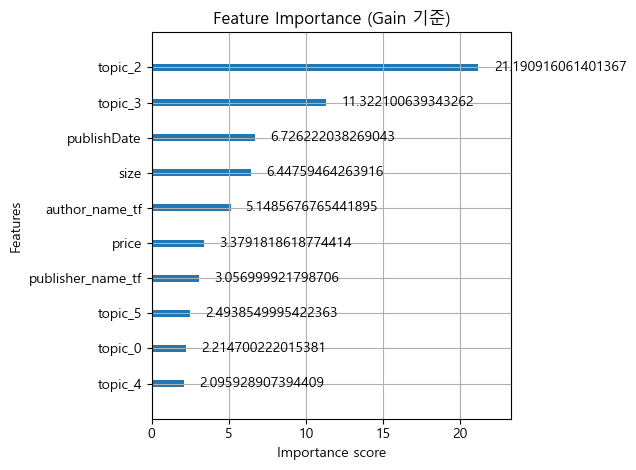

In [32]:
# 피처 중요도 시각화 (Gain 기준)
xgb.plot_importance(best_model, importance_type='gain', max_num_features=10)
plt.title("Feature Importance (Gain 기준)")
plt.tight_layout()
plt.show()

c:\Users\hc\anaconda3\envs\py310\lib\site-packages\shap\plots\_beeswarm.py:1153: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  pl.tight_layout()
c:\Users\hc\anaconda3\envs\py310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


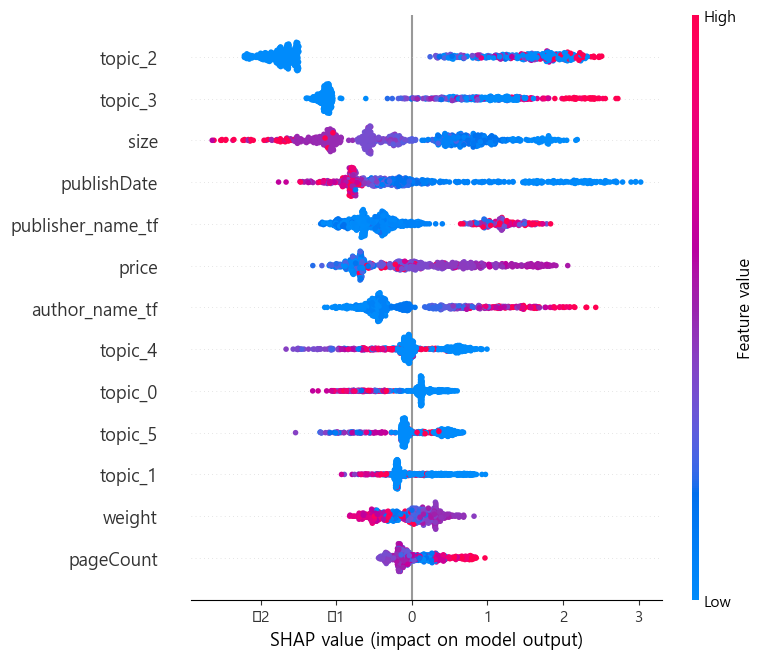

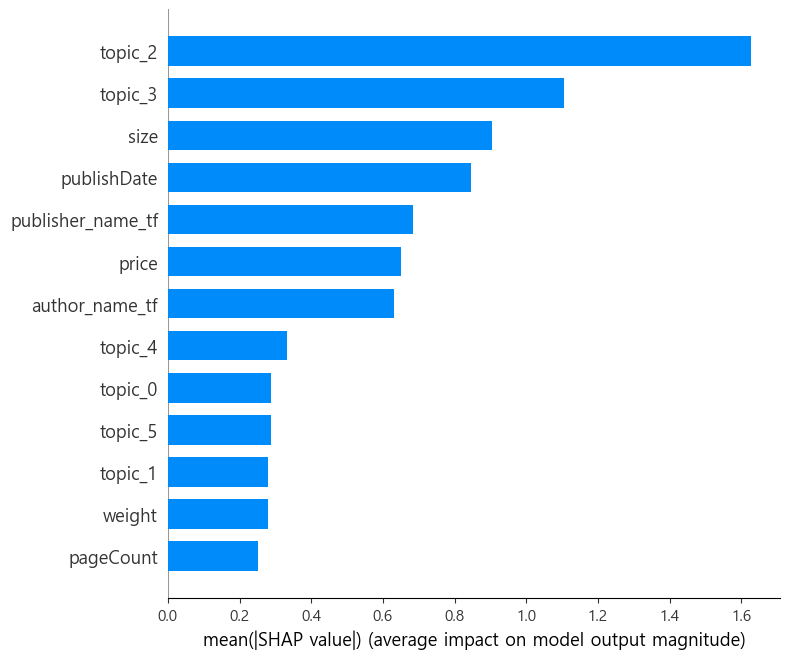

In [33]:
import shap

# SHAP 값 계산
explainer = shap.Explainer(best_model, X_train)
shap_values = explainer(X_val)

# 요약 시각화 (Summary plot)
shap.summary_plot(shap_values, X_val)
shap.summary_plot(shap_values, X_val, plot_type="bar")

In [34]:
print("Train Accuracy:", accuracy_score(y_train, best_model.predict(X_train)))
print("Val Accuracy:", accuracy_score(y_val, best_model.predict(X_val)))

Train Accuracy: 0.999138302455838
Val Accuracy: 0.9547511312217195
